# Map between two states and get free energy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.6
# %env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.6


In [3]:
import jax
import equinox as eqx
import logging
import git
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
from dataclasses import asdict
from typing import cast

from rigid_flows.data import DataWithAuxiliary
from rigid_flows.density import KeyArray, OpenMMDensity
from rigid_flows.flow import RigidWithAuxiliary, build_flow
from rigid_flows.reporting import Reporter
from rigid_flows.specs import ExperimentSpecification
from rigid_flows.train import run_training_stage
from rigid_flows.utils import scanned_vmap

from flox._src.flow.api import Transform
from flox.flow import Pipe
from flox.util import key_chain


2023-02-27 20:46:23.712336: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-02-27 20:46:23.712482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-02-27 20:46:23.712492: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
logging.getLogger().setLevel(logging.INFO)

def setup_model(key: KeyArray, specs: ExperimentSpecification):
    chain = key_chain(key)

    logging.info("Loading base density.")
    num_datapoints = specs.model.base.num_samples
    if num_datapoints is not None:
        logging.info(f'  taking only {num_datapoints} samples from MD')
        selection = np.s_[:num_datapoints]
    else:
        selection = np.s_[:]
    base = OpenMMDensity.from_specs(
        specs.model.use_auxiliary, specs.model.base, selection
    )

    logging.info(f"Loading target density.")
    num_datapoints = specs.model.target.num_samples
    if num_datapoints is not None:
        logging.info(f'  taking only {num_datapoints} samples from MD')
        selection = np.s_[:num_datapoints]
    else:
        selection = np.s_[:]
    target = OpenMMDensity.from_specs(
        specs.model.use_auxiliary, specs.model.target, selection
    )

    logging.info(f"Setting up flow model.")
    flow = build_flow(
        next(chain),
        specs.model.base.num_molecules,
        specs.model.use_auxiliary,
        specs.model.flow,
    )

    if specs.model.pretrained_model_path is not None:
        logging.info(
            f"Loading pre-trained model from {specs.model.pretrained_model_path}."
        )
        flow = cast(
            Pipe[DataWithAuxiliary, RigidWithAuxiliary],
            eqx.tree_deserialise_leaves(
                specs.model.pretrained_model_path, flow
            ),
        )

    return base, target, flow


def train(
    key: KeyArray,
    run_dir: str,
    specs: ExperimentSpecification,
    base: OpenMMDensity,
    target: OpenMMDensity,
    flow: Transform[DataWithAuxiliary, DataWithAuxiliary],
    tot_iter: int,
    loss_reporter: list | None = None,
) -> Transform[DataWithAuxiliary, DataWithAuxiliary]:
    chain = key_chain(key)
    repo = git.Repo(search_parent_directories=True)
    branch = repo.active_branch.name
    sha = repo.head.object.hexsha

    log = asdict(specs)
    log["git"] = {"branch": branch, "sha": sha}
    logging.info(f"Starting training.")
    reporter = Reporter(
        base,
        target,
        run_dir,
        specs.reporting,
        scope=None,
    )
    reporter.with_scope(f"initial").report_model(next(chain), flow, tot_iter)
    for stage, train_spec in enumerate(specs.train):
        flow = run_training_stage(
            next(chain),
            base,
            target,
            flow,
            train_spec,
            specs.model.target,
            reporter.with_scope(f"training_stage_{stage}"),
            tot_iter,
            loss_reporter,
        )
        tot_iter += train_spec.num_iterations
    return flow

def count_params(model):
    return jax.tree_util.tree_reduce(
        lambda s, n: s + n.size if eqx.is_array(n) else s, model, jnp.zeros((), dtype=jnp.int32)).item()

def jitvmap(fn, batch_size=None):
    if batch_size is None:
        return jax.jit(jax.vmap(fn))
    else:
        return jax.jit(scanned_vmap(fn, batch_size))

hist_kwargs = {"bins": "auto", "density": True, "alpha": 0.5}

In [5]:
logdir = "testing"
specs_file = "testing.yaml"
specs = ExperimentSpecification.load_from_file(specs_file)

chain = key_chain(specs.seed)
base, target, flow = setup_model(next(chain), specs)
model = base.omm_model.model

tot_iter = specs.global_step if specs.global_step is not None else 0

print(f'tot flow parameters: {count_params(flow):_}')

INFO:root:Loading base density.
INFO:root:  taking only 10000 samples from MD
INFO:root:Loading OpenMM model specs from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/model-iceXI_T250_N128.json
INFO:root:Loading data from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/MDtraj-iceXI_T250_N128.npz
INFO:root:Loading target density.
INFO:root:  taking only 10000 samples from MD
INFO:root:Loading OpenMM model specs from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/model-iceXI_T100_N128.json
INFO:root:Loading data from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/MDtraj-iceXI_T100_N128.npz
INFO:root:Setting up flow model.


tot flow parameters: 2_109_440


In [6]:
try:
    ref_file = f"data/water/DeltaF_estimates/DF-{specs.model.base}-{specs.model.target}.txt"
    reference_deltaF, reference_deltaF_std = np.loadtxt(ref_file, unpack=True)
except FileNotFoundError:
    reference_deltaF, reference_deltaF_std = None, None

reference_deltaF, reference_deltaF_std

(-5314.32432, 0.10492)

In [7]:
num_samples = 1_000

keys = jax.random.split(next(chain), num_samples)
base_tr = jitvmap(base.sample)(keys)

mapped_tr = jitvmap(flow.forward)(base_tr.obj)

keys = jax.random.split(next(chain), num_samples)
target_tr = jitvmap(target.sample)(keys)

logw = base_tr.ldj + mapped_tr.ldj - jitvmap(target.potential)(mapped_tr.obj)
(jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()

-5140.53564453125

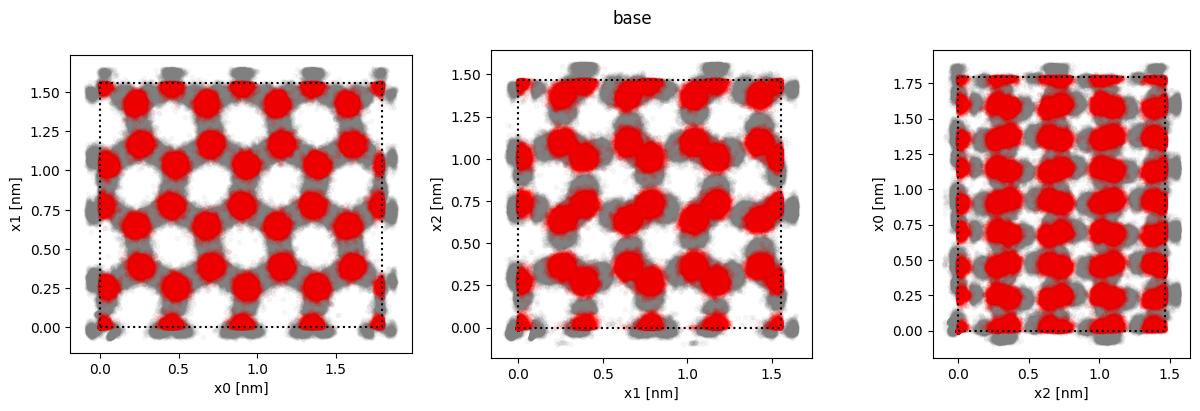

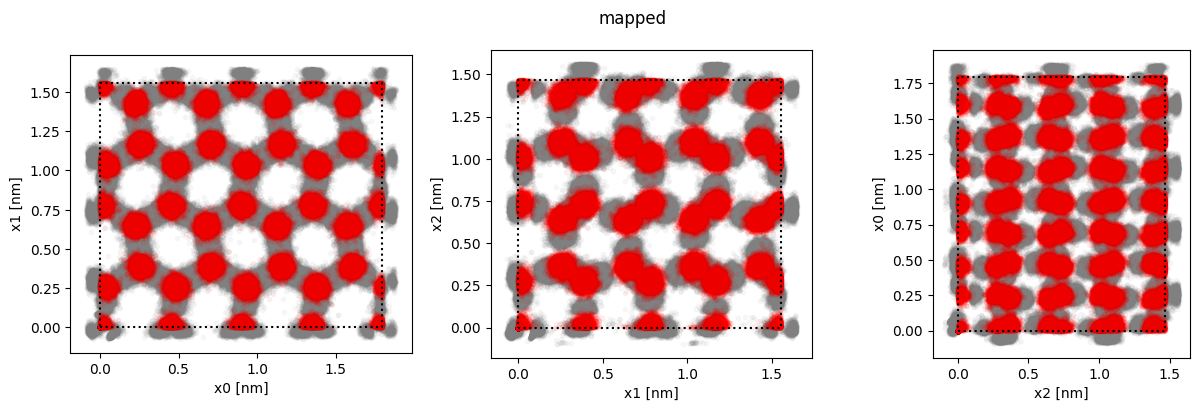

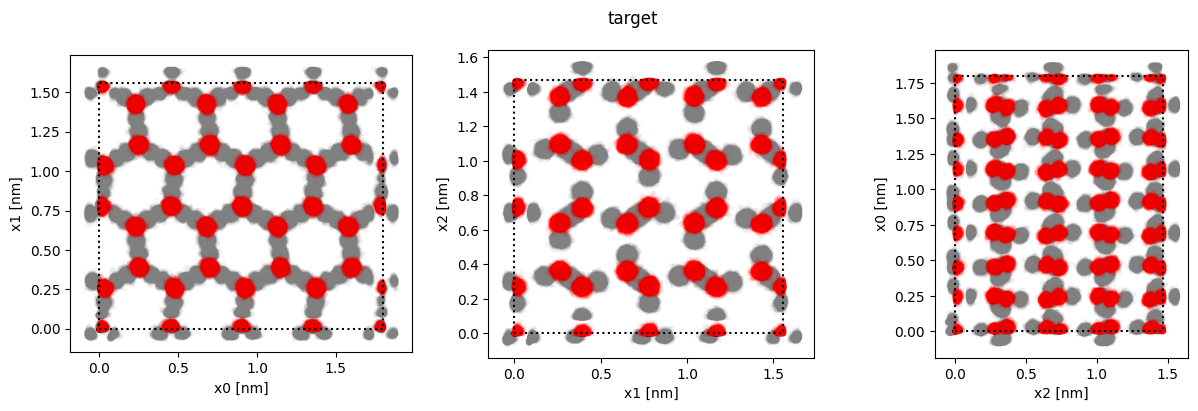

In [8]:
toPBC = False
model.plot_2Dview(base_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title='base')
model.plot_2Dview(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title='mapped')
model.plot_2Dview(target_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title='target')

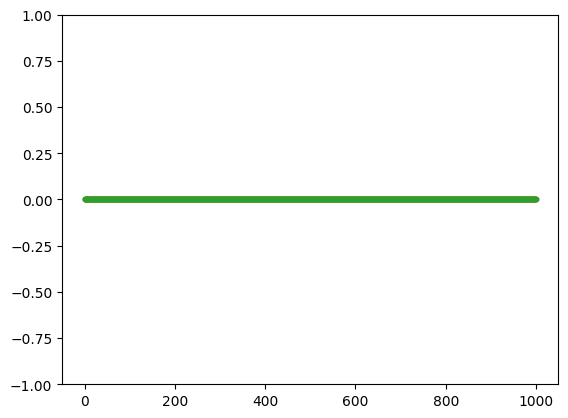

In [9]:
## closer look at the center of mass
# plt.plot(base_tr.obj.pos[:,:,0].mean(axis=(1)), '.')
# plt.plot(mapped_tr.obj.pos.mean(axis=(1,2)), '.')
# plt.show()
# shift = base_tr.obj.pos[:,:,0].mean(axis=(1)) - mapped_tr.obj.pos[:,:,0].mean(axis=(1))
shift = mapped_tr.obj.pos[:,0,0] - base_tr.obj.pos[:,0,0]
plt.plot(shift/base.data.box, '.')
plt.ylim(-1,1)
plt.show()

In [10]:
%%time

!cp {specs_file} {logdir}/config.yaml

loss_reporter = []
flow = train(next(chain), logdir, specs, base, target, flow, tot_iter, loss_reporter)

INFO:root:Starting training.
INFO:root:preparing report
INFO:root:sampling from data
INFO:root:sampling from prior
INFO:root:sampling from model
INFO:root:Saving artifacts to testing/initial
INFO:root:Saving model to testing/initial/model.eqx
INFO:root:reporting ESS = 1.3467202186584473
Epoch: 1/3: 100%|██████████| 1000/1000 [00:49<00:00, 20.21it/s, loss=-5296.722]
INFO:root:preparing report
INFO:root:sampling from data
INFO:root:sampling from prior
INFO:root:sampling from model
INFO:root:Saving artifacts to testing/training_stage_0/epoch_0
INFO:root:Saving model to testing/training_stage_0/epoch_0/model.eqx
INFO:root:reporting ESS = 5.321450710296631
Epoch: 2/3: 100%|██████████| 1000/1000 [00:35<00:00, 28.43it/s, loss=-5302.3223]
INFO:root:preparing report
INFO:root:sampling from data
INFO:root:sampling from prior
INFO:root:sampling from model
INFO:root:Saving artifacts to testing/training_stage_0/epoch_1
INFO:root:Saving model to testing/training_stage_0/epoch_1/model.eqx
INFO:root:r

CPU times: user 3min 17s, sys: 25.9 s, total: 3min 43s
Wall time: 2min 49s


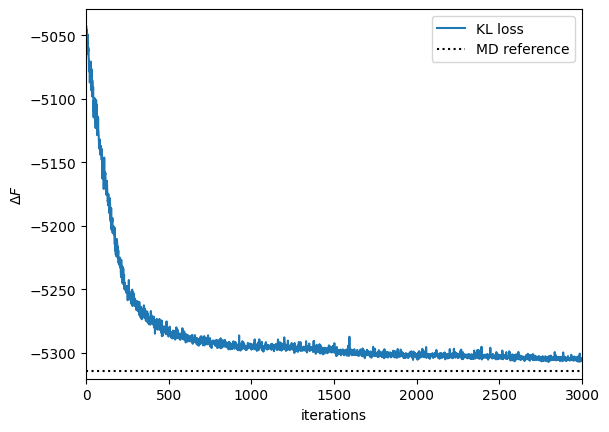

In [11]:
plt.plot(loss_reporter, label='KL loss')
if reference_deltaF is not None:
    plt.axhline(reference_deltaF, c="k", ls=":", label='MD reference')
plt.xlim(0, len(loss_reporter))
plt.xlabel('iterations')
plt.ylabel('$\Delta F$')
plt.legend()
plt.show()

In [12]:
mapped_tr = jitvmap(flow.forward)(base_tr.obj)

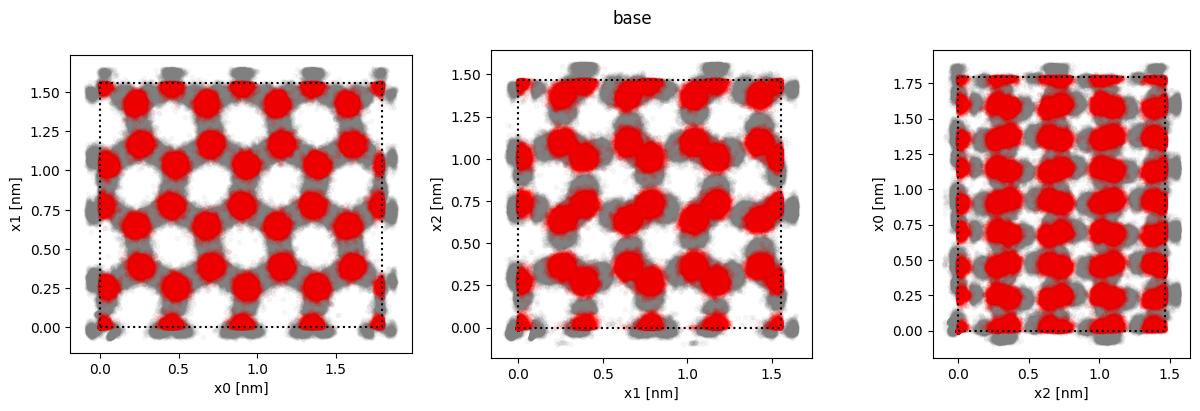

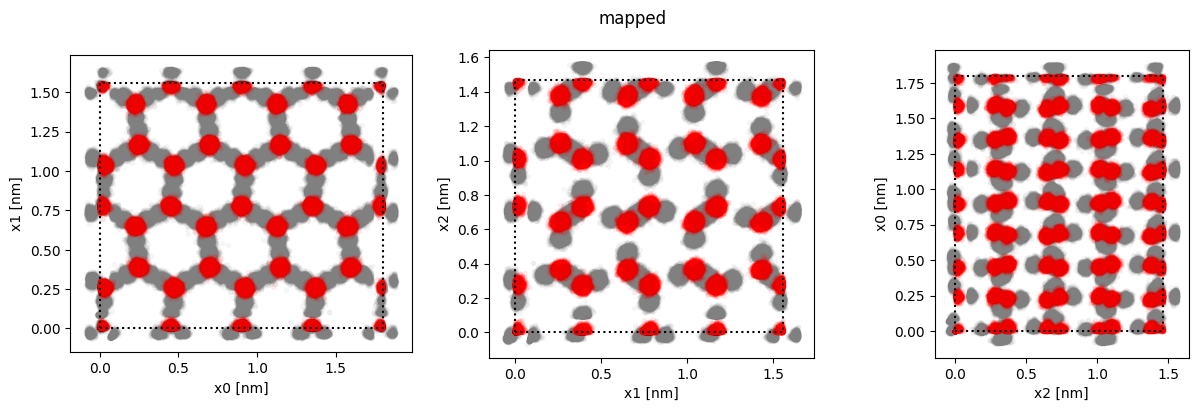

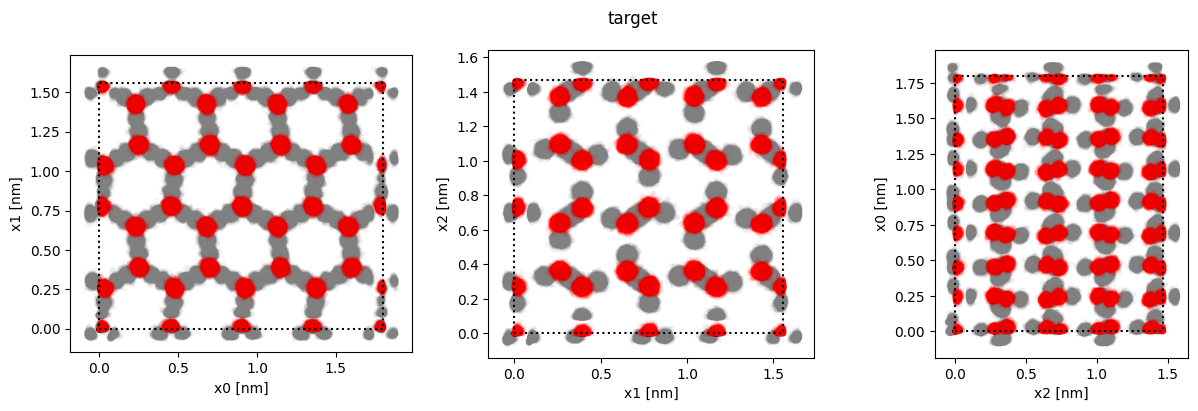

In [13]:
model.plot_2Dview(base_tr.obj.pos.reshape(-1, model.n_atoms, 3),   toPBC=toPBC, title='base')
model.plot_2Dview(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title='mapped')
model.plot_2Dview(target_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title='target')

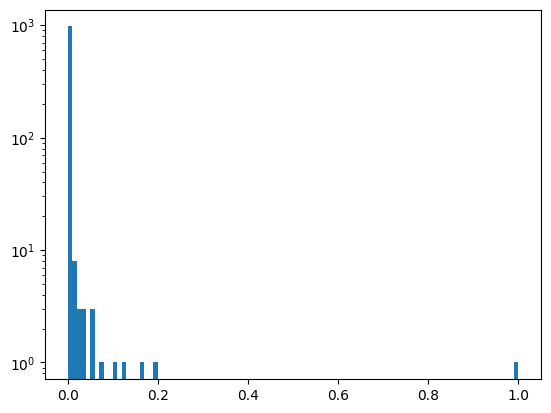

ESS = 4.8982  ->  0.49%


In [14]:
def ess(logw):
    return jnp.exp(2*jax.scipy.special.logsumexp(logw)-jax.scipy.special.logsumexp(2*logw))

## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)

plt.hist(jnp.exp(logw-logw.max()), bins=100)
plt.yscale('log')
plt.show()

print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')

In [15]:
ene_fn = jitvmap(target.potential)
base_ene = ene_fn(base_tr.obj)
mapped_ene = ene_fn(mapped_tr.obj)
target_ene = ene_fn(target_tr.obj)

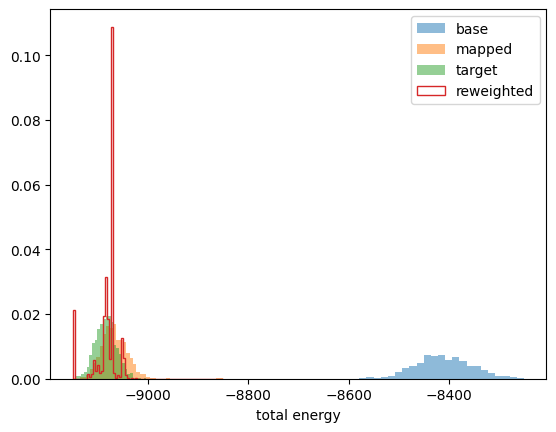

In [16]:
plt.hist(base_ene, **hist_kwargs, label='base')
plt.hist(mapped_ene, **hist_kwargs, label='mapped')
plt.hist(target_ene, **hist_kwargs, label='target')
plt.hist(mapped_ene, weights=np.exp(logw-jax.scipy.special.logsumexp(logw)), bins=75, histtype='step', density=True, label='reweighted')
plt.xlabel('total energy')
plt.legend()
plt.show()

In [17]:
ene_label = 'omm'
scaling = 1
if ene_label == 'omm':
    scaling = target.omm_model.kbT
base_ene2 = target.compute_energies(base_tr.obj, True, True, True)[ene_label] * scaling
target_ene2 = target.compute_energies(target_tr.obj, True, True, True)[ene_label] * scaling
mapped_ene2 = target.compute_energies(mapped_tr.obj, True, True, True)[ene_label] * scaling

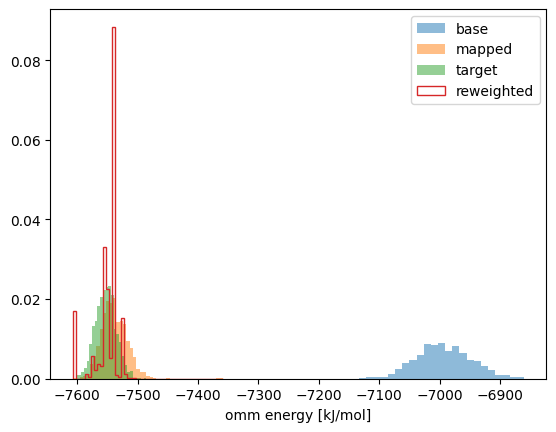

In [18]:
plt.hist(base_ene2, **hist_kwargs, label='base')
plt.hist(mapped_ene2, **hist_kwargs, label='mapped')
plt.hist(target_ene2, **hist_kwargs, label='target')
plt.hist(mapped_ene2, weights=np.exp(logw-jax.scipy.special.logsumexp(logw)), bins=50, histtype='step', density=True, label='reweighted')
plt.xlabel(ene_label + ' energy [kJ/mol]') #it's kJ/mol only for omm energies
plt.legend()
plt.show()

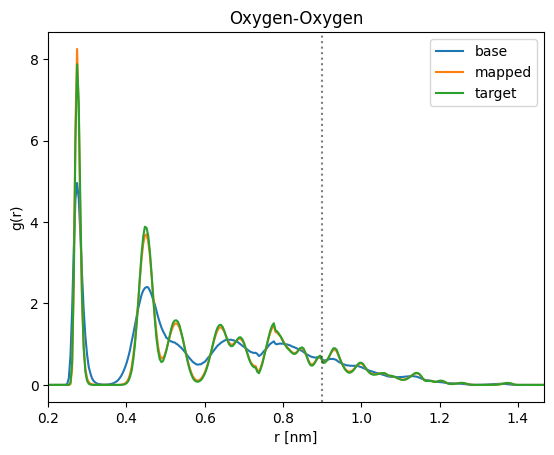

In [19]:
r_range = [0.2, np.diag(model.box).min()]
n_bins = 300
plt.title('Oxygen-Oxygen')
model.plot_rdf(base_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='base')
model.plot_rdf(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='mapped')
model.plot_rdf(target_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='target')
plt.axvline(model.box.max()/2, c='k', ls=':', alpha=.5)
plt.legend()
plt.show()

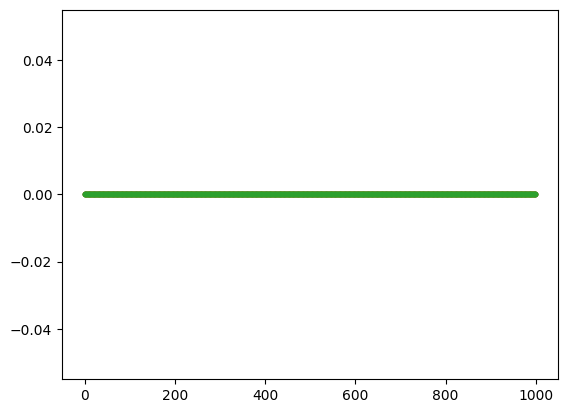

In [20]:
## closer look at the center of mass
# com_pos = mapped_tr.obj.pos.mean(axis=(1,2))
# plt.plot(com_pos, '.')
# com_shift = base_tr.obj.pos[:,:,0].mean(axis=(1)) - mapped_tr.obj.pos[:,:,0].mean(axis=(1))
# plt.plot(com_shift, '.')
# plt.show()
# for i in range(3):
#     plt.hist(com_pos[:,i], **hist_kwargs)
# plt.show()

# plt.plot(mapped_tr.obj.pos[:,0,0])
# plt.show()
 
shift = base_tr.obj.pos[:,0,0] - mapped_tr.obj.pos[:,0,0]
plt.plot(shift, '.')
plt.show()

In [21]:
## TFEP
deltaF = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
print(f'Estimated deltaF from TFEP (below) = {deltaF:g}')
if reference_deltaF is not None:
    print(f'                  Reference deltaF = {reference_deltaF:g}')

Estimated deltaF from TFEP (below) = -5312.51
                  Reference deltaF = -5314.32


In [22]:
def estimate_deltaF(key, num_samples, base):
    keys = jax.random.split(key, num_samples)
    base_tr = jitvmap(base.sample)(keys)
    mapped_tr = jitvmap(flow.forward)(base_tr.obj)
    logw = base_tr.ldj + mapped_tr.ldj - jitvmap(target.potential)(mapped_tr.obj)
    return (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()

eval_base = OpenMMDensity.from_specs(specs.model.use_auxiliary, specs.model.base, np.s_[-specs.model.base.num_samples:])
eval_base.data.pos.shape[0]

INFO:root:Loading OpenMM model specs from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/model-iceXI_T250_N128.json
INFO:root:Loading data from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/MDtraj-iceXI_T250_N128.npz


10000

In [23]:
estimate_from_training = False #this gives a biased estimate, always lower

from tqdm import trange

#FIXME: it's maybe better to use all MD points instead of random samples
iterations = 5
n_samples = 1000 

if estimate_from_training:
    deltaFs = np.zeros(iterations)
    for i in trange(iterations):
        deltaFs[i] = estimate_deltaF(next(chain), n_samples, base)
    print(f'deltaF = {deltaFs.mean():g} +/- {deltaFs.std():g}')

eval_deltaFs = np.zeros(iterations)
for i in trange(iterations):
    eval_deltaFs[i] = estimate_deltaF(next(chain), n_samples, eval_base)
    print(eval_deltaFs[i], end='\r')
eval_deltaFs.mean(), eval_deltaFs.std()
print(f'deltaF = {eval_deltaFs.mean():g} +/- {eval_deltaFs.std():g}')

 20%|██        | 1/5 [00:05<00:21,  5.45s/it]

 40%|████      | 2/5 [00:10<00:16,  5.50s/it]

 60%|██████    | 3/5 [00:15<00:10,  5.22s/it]

 80%|████████  | 4/5 [00:21<00:05,  5.34s/it]

100%|██████████| 5/5 [00:27<00:00,  5.45s/it]

deltaF = -5312.89 +/- 1.08918


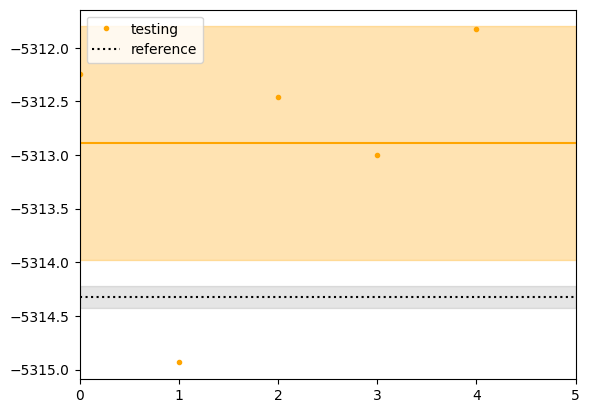

In [24]:
xlim = [0, len(eval_deltaFs)]
if estimate_from_training:
    plt.plot(deltaFs, '.', c='blue', label='training')
    x = 2 * [deltaFs.mean()]
    plt.fill_between(xlim, x-deltaFs.std(), x+deltaFs.std(), color='blue', alpha=0.3)
    plt.axhline(deltaFs.mean(), c='blue')
plt.plot(eval_deltaFs, '.', c='orange', label='testing')
x = 2 * [eval_deltaFs.mean()]
plt.fill_between(xlim, x-eval_deltaFs.std(), x+eval_deltaFs.std(), color='orange', alpha=0.3)
plt.axhline(eval_deltaFs.mean(), c='orange')
if reference_deltaF is not None:
    plt.axhline(reference_deltaF, c='k', ls=":", label='reference')
    x = np.array(2 * [reference_deltaF])
    plt.fill_between(xlim, x-reference_deltaF_std, x+reference_deltaF_std, color='k', alpha=0.1)
plt.xlim(xlim)
plt.legend()
plt.show()